# 10. Milestone Project 2: SkimLit 📄🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from extras.helper_functions import create_tensorboard_callback, calculate_results, compare_historys, plot_loss_curves
import tensorflow as tf

%matplotlib inline
tf.__version__

'2.9.1'

## Machine Learning Engineer

1. Download a paper
2. Implement it
3. Keep doing this until you have skills

Raw Abstract Text -> Model (SkimLit) -> Model predicts topic of each sequence

## What we're going to cover

* Downloading a text dataset (PubMed 200K RCT)
* Writing a preprocessing function for our data
* Setting up multiple modelling experiments with different levels of embeddings
* Building a multimodal model to take in different sources of data
    * Replicating the model powering https://arxiv.org/abs/1710.06071
* Finding the most wrong prediction examples

What section should a sentence belong to? -> SkimLit -> Class [Background, Objective, Methods, Results, Conclusion]

In [2]:
!nvidia-smi

Sat Jul 16 09:12:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   44C    P8     6W /  N/A |     82MiB /  6144MiB |     25%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get Data 

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the author's GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
Updating files:  61% (8/13)
Updating files:  69% (9/13)
Updating files:  76% (10/13)
Updating files:  84% (11/13)
Updating files:  92% (12/13)
Updating files: 100% (13/13)
Updating files: 100% (13/13), done.


In [4]:
import shutil

shutil.move("pubmed-rct", "Data/NLP/SkimLit")

'Data/NLP/SkimLit\\pubmed-rct'

In [5]:
os.listdir("Data/NLP/SkimLit/PubMed_20k_RCT_numbers_replaced_with_at_sign")

['dev.txt', 'test.txt', 'train.txt']

In [6]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "Data/NLP/SkimLit/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [7]:
filenames = [data_dir + "/" +file for file in os.listdir(data_dir)]
filenames

['Data/NLP/SkimLit/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'Data/NLP/SkimLit/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'Data/NLP/SkimLit/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocessing Data

### Method 1: Using Tensors

In [8]:
train_dataset = tf.data.TextLineDataset([data_dir + "/train.txt"])
val_dataset = tf.data.TextLineDataset([data_dir + "/dev.txt"])
test_dataset = tf.data.TextLineDataset([data_dir + "/test.txt"])

In [9]:
def remove_data(ds):
    return ds.filter(lambda x: tf.strings.regex_full_match(x, "#{3}[0-9]{8}") == False and tf.strings.length(x) != 0)

def preprocess_data(line):
    data = tf.strings.strip(tf.strings.regex_replace(line, "^[A-Z]+", ""))
    return data

def preprocess_labels(line):
    label = tf.strings.regex_replace(line, r"[^A-Z]+\S+","")
    return label

def data_preparation(dataset):
    return dataset.apply(remove_data).map(map_func = preprocess_data, num_parallel_calls = tf.data.AUTOTUNE), dataset.apply(remove_data).map(map_func = preprocess_labels, num_parallel_calls = tf.data.AUTOTUNE)

In [10]:
train_data, train_labels = data_preparation(train_dataset)
val_data, val_labels = data_preparation(val_dataset)
test_data, test_labels = data_preparation(test_dataset)

However this has a major drawback in that it becomes agnostic to the abstract ID.

### Method 2

Before going to method 2, lets take a small detour.

In [11]:
for data, label in zip(train_data.as_numpy_iterator(), train_labels.as_numpy_iterator()):
    print(data, label)
    break

b'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .' b'OBJECTIVE'


In [42]:
import re
def read_files(filepath):
    data_dir = "Data/NLP/SkimLit/PubMed_20k_RCT_numbers_replaced_with_at_sign"
    files = [data_dir + "/" +file for file in os.listdir(data_dir)]
    abstract_idx = ""
    filepath = files[filepath]
    with open(filepath) as file:
        for line in file.readlines():
            if re.search(r"#{3}[0-9]{8}", line) != None:
                continue
            elif len(line) == 0:
                continue
            label = re.search(r"^[A-Z]+", line)
            if label != None:
                label = label[0]
                data = line.replace(label, "").strip()
                yield data, label

i = 0
for data, label in read_files(2):
    print(data, label)
    print("*"*80)
    i += 1
    if i == 10:
        break

To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) . OBJECTIVE
********************************************************************************
A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks . METHODS
********************************************************************************
Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers . METHODS
********************************************************************************
Pain was assessed using the visual analog pain scale ( @-@ mm ) . METHODS
********************************************************************************
Secondary outcome measures included the West

In [45]:
train_dataset_prepared = tf.data.Dataset.from_generator(lambda: read_files(2), output_types = (tf.string, tf.string), output_shapes = (None, None))
for data, label in train_dataset_prepared.as_numpy_iterator():
    print(data, label)
    break

b'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .' b'OBJECTIVE'


The above is another alternative to get data. However, since it relies on a generator, it's inherently slower than method 1.

Let's think about how we want our data to look...

The best way to represent our data would be akin to

```
[
    {
        'line_number': 0,
        'target': 'BACKGROUND',
        'text': 'Emotional eating is associated with overeating and the development of obesity .\n'
        'total_lines': 11
    }, ....
]
```

In [52]:
def get_lines(filepath):
    with open(filepath) as file:
        return file.readlines()

def preprocess_text_with_line_numbers(filepath):
    """
    Returns a list of dictionaries of abstract line data

    Takes in a filename, reads its contents and sorts through each line, extracting things like the target label, the text of the sentence, how many sentences are in the current abstract and what sentence number the target line is.
    """
    input_lines = get_lines(filepath) # get all lines from filename
    abstract_lines = " # create an empty abstract"
    abstract_samples = [] # create an empty list of abstracts

    # Loop through each line in the target file
    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines
            # Iterate through each line in a particular abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0] # get target label
                line_data["text"] = target_text_split[1].lower() # get target text and lower it.
                line_data["total_lines"] = len(abstract_line_split) - 1 # how many lines are there in the target abstract? (start from 0)
                abstract_samples.append(line_data)
        else: # if the above conditions arent fulfilled, the line contains a labelled sentence
            abstract_lines += line
    
    return abstract_samples


In [53]:
# Get data from file and preprocess it

train_samples = preprocess_text_with_line_numbers(data_dir + "/train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "/dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "/test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [55]:
# Check the first abstract of our trainining data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is in the form of a list of dictionaries, how about we turn it into a DataFrame to further visualise it.

In [56]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [58]:
train_df.head(14)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


In [59]:
# Distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

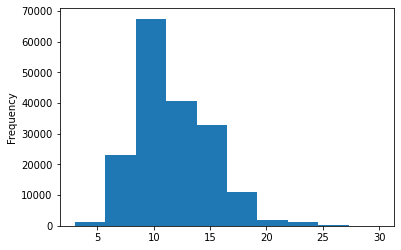

In [61]:
# Lets check the length of different lines
train_df.total_lines.plot.hist();

## Get lists of sentences

In [63]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [64]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [67]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse = False) # we want non-sparse matrix

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

### Label encode labels

In [68]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [70]:
# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [71]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Experiments we're running
|Experiment|Model|
|----------|-----|
|0|Naive Bayes with TF-IDF encoder (baseline)|
|1|Conv1D with token embeddings|
|2|TensorFlow Pretrained Feature Extractor|
|3|Conv1D with character embeddings|
|4|Pretrained token embeddings (same as 2) + character embeddings (same as 3)|
|5|Pretrained token embeddings + character embeddings + positional embeddings|

## Starting with a series of modelling experiments...

As usual we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier)

## Model 0: Naive Bayes with TF-IDF encoder 

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

model_0 = Pipeline(
    [
        ('tf_idf_vectorizer', TfidfVectorizer()),
        ('classifier_layer', MultinomialNB())
    ]
)

model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tf_idf_vectorizer', TfidfVectorizer()),
                ('classifier_layer', MultinomialNB())])

In [75]:
model_0_preds = model_0.predict(val_sentences)
baseline_results = calculate_results(val_labels_encoded, model_0_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [76]:
from extras.helper_functions import make_confusion_matrix

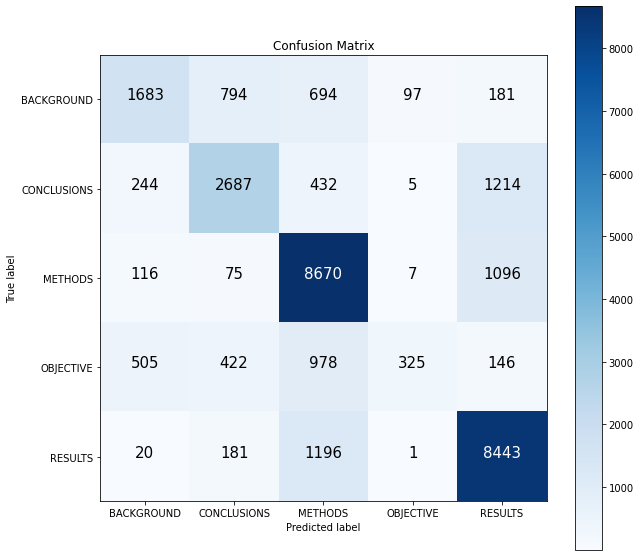

In [79]:
make_confusion_matrix(val_labels_encoded, model_0_preds, classes = list(class_names))